In [1]:
# -- Set a GPS time:
t0 = 1126259462.4    # -- GW150914

#-- Choose detector as H1, L1, or V1
detector = 'H1'

#Example times in H1 detector:

t0 = 1126259462.4    # -- GW150914

#t0 = 1187008882.4    # -- GW170817 USE 2017 DATA LATERRRR


In [2]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

try:
    from gwpy.timeseries import TimeSeries
except:
    ! pip install -q "gwpy<2.1"
    ! pip install -q "matplotlib<3.3"
    from gwpy.timeseries import TimeSeries

import os
import datetime as dt
import six
import numpy as np
import h5py

/Users/sophiewillis/opt/anaconda3/lib/python3.9/site-packages/h5py/__init__.py:72: UserWarning: h5py is running against HDF5 1.10.6 when it was built against 1.8.4, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
!pip3 install --upgrade pip && pip3 install h5py=='2.9.0'
import numpy as np
import json
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from IPython.display import Audio
from scipy.io import wavfile
import h5py
import matplotlib.mlab as mlab
#For plotting
import matplotlib.pyplot as plt
!pip install gwosc
%matplotlib inline

In [4]:
!pip install gwosc
#!pip3 install readligo
import readligo as rl

In [5]:
from gwosc.locate import get_urls
url = get_urls(detector, t0, t0)[-1]

print('Downloading: ' , url)
fn = os.path.basename(url)
with open(fn,'wb') as strainfile:                 
    straindata = requests.get(url)
    strainfile.write(straindata.content)

Downloading:  https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


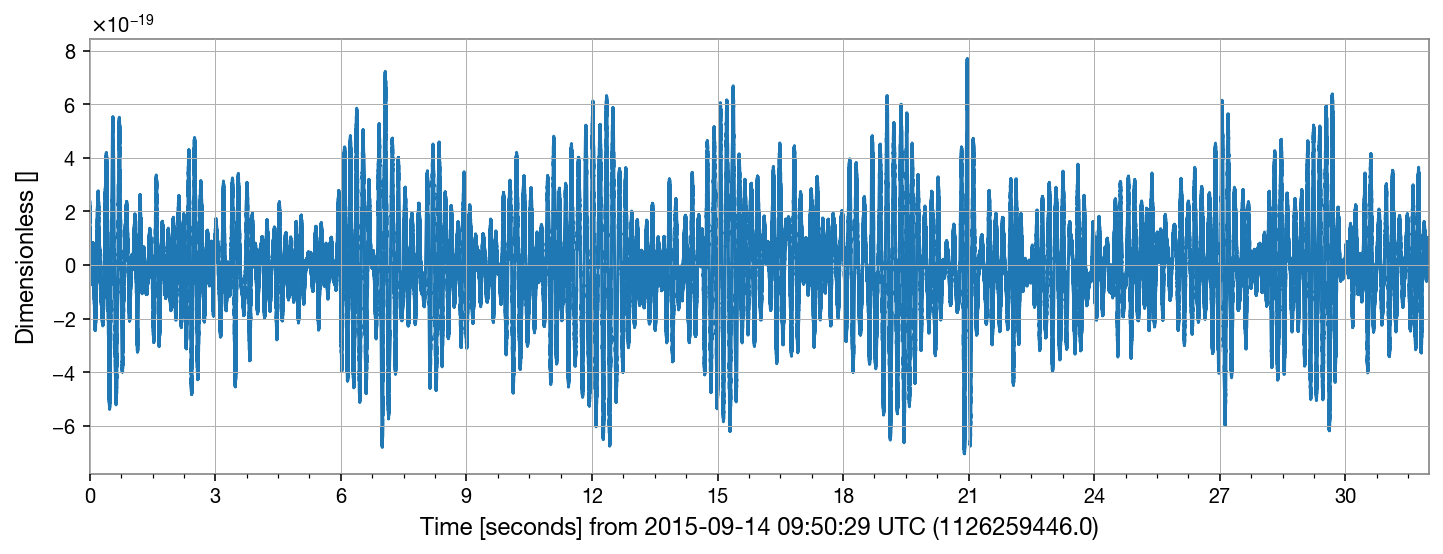

In [6]:
# -- Read strain data
strain = TimeSeries.read(fn,format='hdf5.losc')
center = int(t0)
strain = strain.crop(center-16, center+16)
fig1 = strain.plot()

#just use tutorials to find time of merger
#compare our value to known time (to the millisecond)
#harmonics/ unknown sources of noise from the instruments

(1e-24, 1e-19)

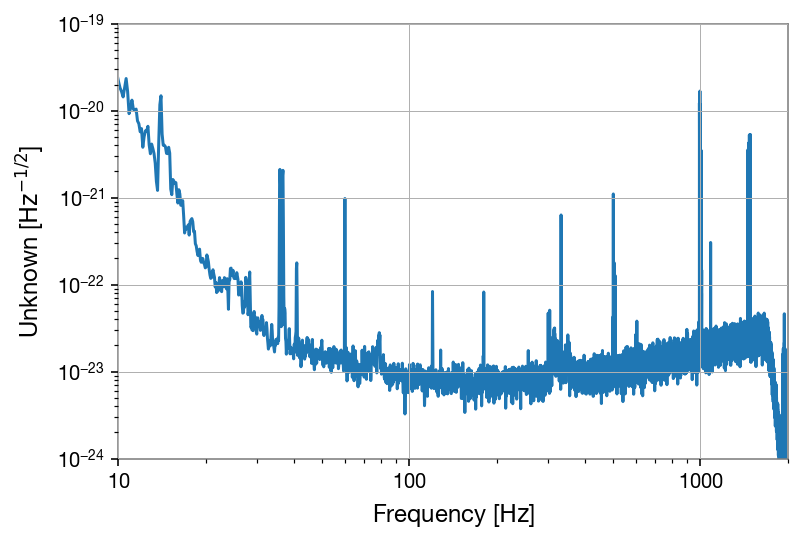

In [7]:
# -- Plot ASD
fig2 = strain.asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)

(1126259462.2, 1126259462.5)

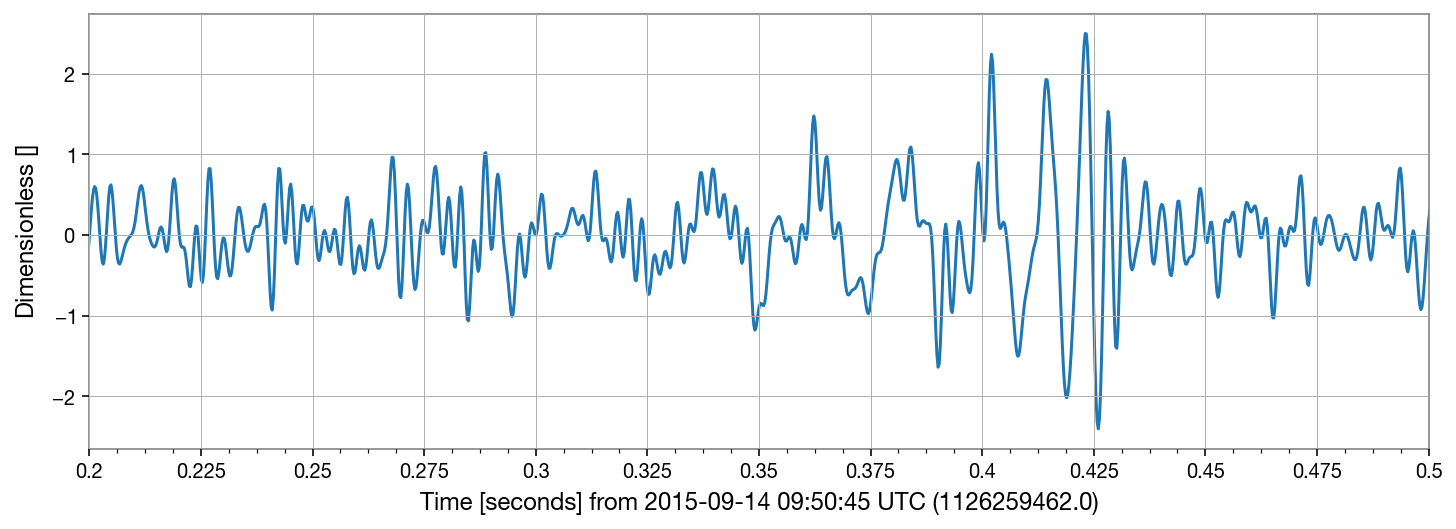

In [8]:
# -- Whiten and bandpass data
white_data = strain.whiten()
bp_data = white_data.bandpass(30, 400)
fig3 = bp_data.plot()
plt.xlim(t0-0.2, t0+0.1)

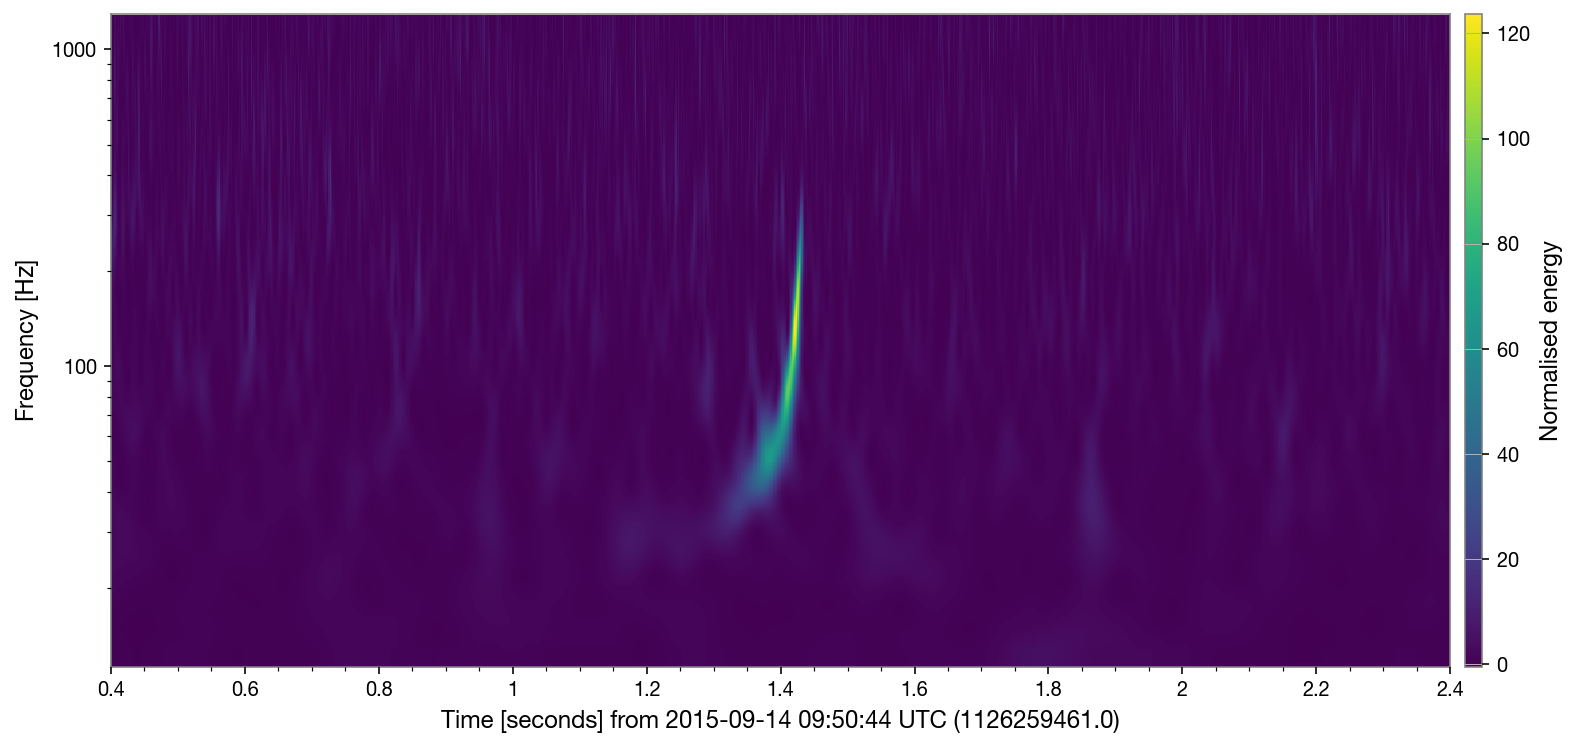

In [9]:
dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(t0-dt, t0+dt))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalised energy")
ax.grid(False)
ax.set_yscale('log')

In [10]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py


# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# LIGO-specific readligo.py 
#import readligo.py as rl

# you might get a matplotlib warning here; you can ignore it.

In [11]:
#-- SET ME   Tutorial should work with most binary black hole events
#-- Default is no event selection; you MUST select one to proceed.
eventname = ''
eventname = 'GW150914' 
#eventname = 'GW151226' 
#eventname = 'LVT151012'
#eventname = 'GW170104'

# want plots?
make_plots = 1
plottype = "png"
#plottype = "pdf"

In [12]:
# Read the event properties from a local json file
import json
fnjson = "BBH_events_v3.json"
eventname = 'GW150914' 
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)
    print("You can download it from https://losc.ligo.org/s/events/"+fnjson)
    print("Quitting.")
    quit()

# did the user select the eventname ?
try: 
    events[eventname]
except:
    print('You must select an eventname that is in '+fnjson+'! Quitting.')
    quit()

In [13]:
# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal
print("Reading in parameters for event " + event["name"])
print(event)

Reading in parameters for event GW150914
{'name': 'GW150914', 'fn_H1': 'H-H1_LOSC_4_V2-1126259446-32.hdf5', 'fn_L1': 'L-L1_LOSC_4_V2-1126259446-32.hdf5', 'fn_template': 'GW150914_4_template.hdf5', 'fs': 4096, 'tevent': 1126259462.44, 'utcevent': '2015-09-14T09:50:45.44', 'm1': 41.743, 'm2': 29.237, 'a1': 0.355, 'a2': -0.769, 'approx': 'lalsim.SEOBNRv2', 'fband': [43.0, 300.0], 'f_min': 10.0}


In [14]:
#----------------------------------------------------------------
# Load LIGO data from a single file.
# FIRST, define the filenames fn_H1 and fn_L1, above.

fn_H1 = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_L1 = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
#----------------------------------------------------------------
try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")
    print("You can download them from https://losc.ligo.org/s/events/"+eventname)
    print("Quitting.")
    quit()

/Users/sophiewillis/opt/anaconda3/lib/python3.9/site-packages/h5py/_hl/dataset.py:312: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  warn("dataset.value has been deprecated. "


In [15]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Let's look at the data and print out some stuff:

print('time_H1: len, min, mean, max = ', \
    len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max() )
print('strain_H1: len, min, mean, max = ', \
    len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max())
print( 'strain_L1: len, min, mean, max = ', \
    len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max())

#What's in chan_dict?  (See also https://losc.ligo.org/tutorials/)
bits = chan_dict_H1['DATA']
print("For H1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))
bits = chan_dict_L1['DATA']
print("For L1, {0} out of {1} seconds contain usable DATA".format(bits.sum(), len(bits)))

time_H1: len, min, mean, max =  131072 1126259446.0 1126259461.999878 1126259477.9997559
strain_H1: len, min, mean, max =  131072 -7.044665943156067e-19 5.895522509246437e-23 7.706262192397465e-19
strain_L1: len, min, mean, max =  131072 -1.8697138664279764e-18 -1.0522332249909908e-18 -4.60035111311666e-20
For H1, 32 out of 32 seconds contain usable DATA
For L1, 32 out of 32 seconds contain usable DATA


1126259462.44


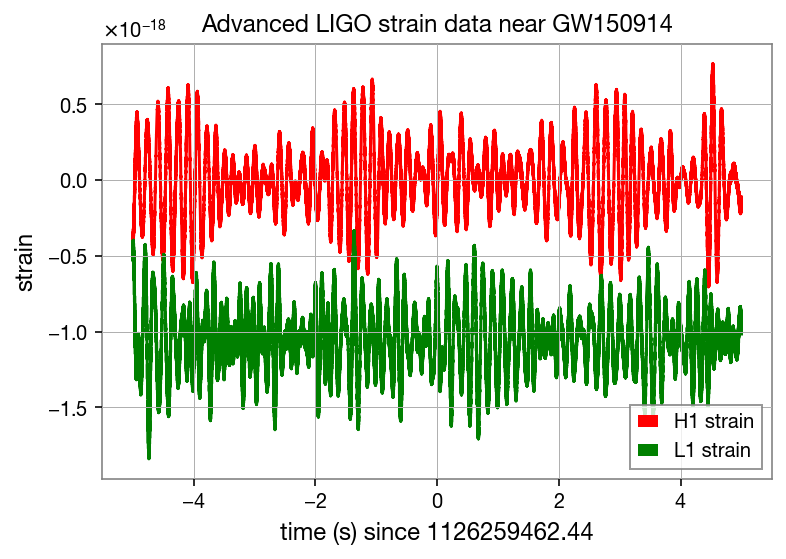

In [16]:
# plot +- deltat seconds around the event:
# index into the strain time series for this time interval:
deltat = 5
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
print(tevent)

if make_plots:
    plt.figure()
    plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
    plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('strain')
    plt.legend(loc='lower right')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_strain.'+plottype)

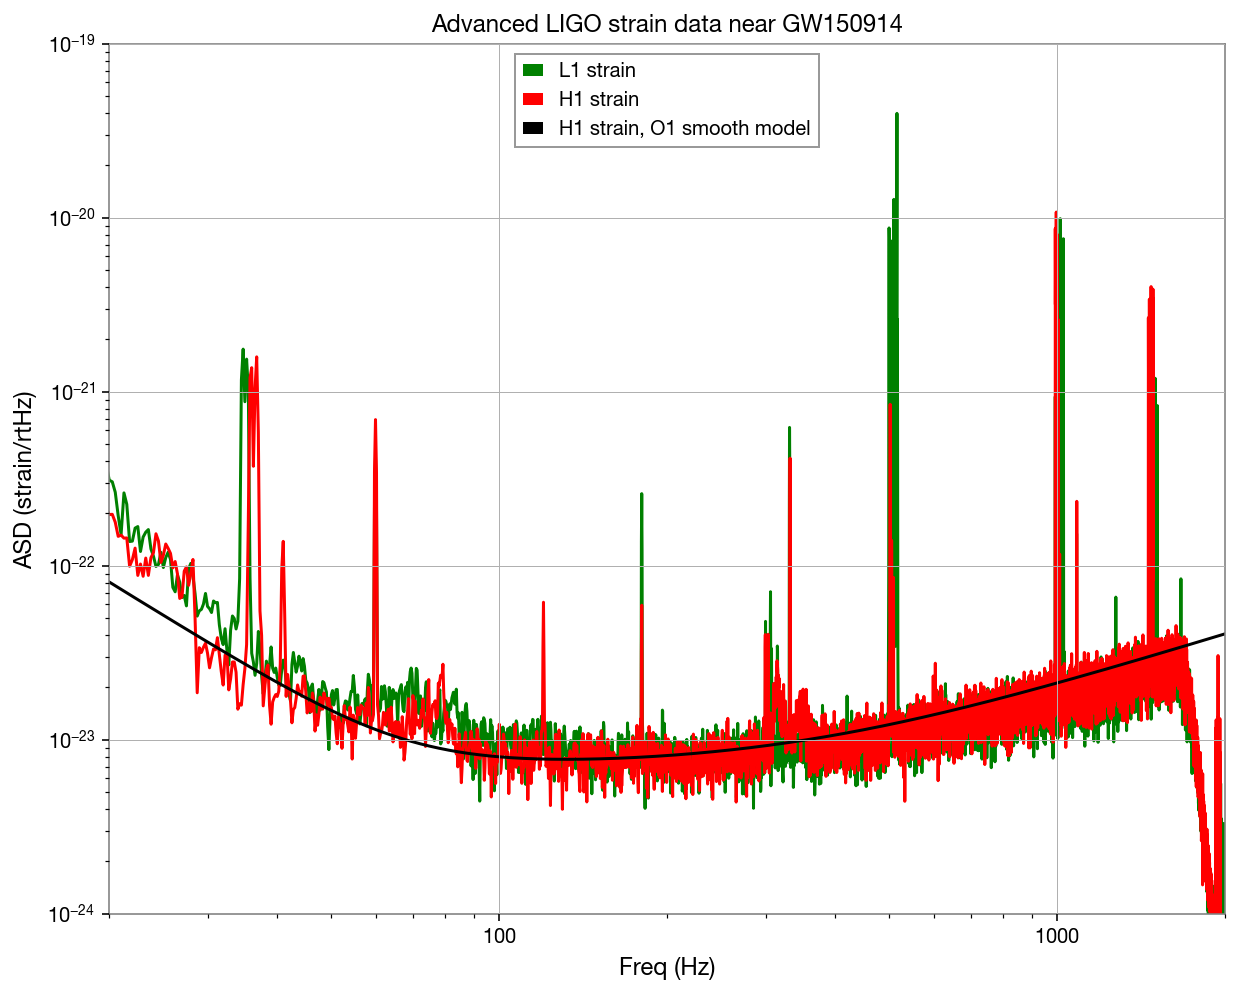

In [17]:
make_psds = 1
if make_psds:
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

    # We will use interpolations of the ASDs computed above for whitening:
    psd_H1 = interp1d(freqs, Pxx_H1)
    psd_L1 = interp1d(freqs, Pxx_L1)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx)

if make_plots:
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
    plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
    plt.loglog(freqs, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain data near '+eventname)
    plt.savefig(eventname+'_ASDs.'+plottype)

In [18]:
BNS_range = 1
if BNS_range:
    #-- compute the binary neutron star (BNS) detectability range

    #-- choose a detector noise power spectrum:
    f = freqs.copy()
    # get frequency step size
    df = f[2]-f[1]

    #-- constants
    # speed of light:
    clight = 2.99792458e8                # m/s
    # Newton's gravitational constant
    G = 6.67259e-11                      # m^3/kg/s^2 
    # one parsec, popular unit of astronomical distance (around 3.26 light years)
    parsec = 3.08568025e16               # m
    # solar mass
    MSol = 1.989e30                      # kg
    # solar mass in seconds (isn't relativity fun?):
    tSol = MSol*G/np.power(clight,3)     # s
    # Single-detector SNR for detection above noise background: 
    SNRdet = 8.
    # conversion from maximum range (horizon) to average range:
    Favg = 2.2648
    # mass of a typical neutron star, in solar masses:
    mNS = 1.4

    # Masses in solar masses
    m1 = m2 = mNS    
    mtot = m1+m2  # the total mass
    eta = (m1*m2)/mtot**2  # the symmetric mass ratio
    mchirp = mtot*eta**(3./5.)  # the chirp mass (FINDCHIRP, following Eqn 3.1b)

    # distance to a fiducial BNS source:
    dist = 1.0                           # in Mpc
    Dist =  dist * 1.0e6 * parsec /clight # from Mpc to seconds

    # We integrate the signal up to the frequency of the "Innermost stable circular orbit (ISCO)" 
    R_isco = 6.      # Orbital separation at ISCO, in geometric units. 6M for PN ISCO; 2.8M for EOB 
    # frequency at ISCO (end the chirp here; the merger and ringdown follow) 
    f_isco = 1./(np.power(R_isco,1.5)*np.pi*tSol*mtot)
    # minimum frequency (below which, detector noise is too high to register any signal):
    f_min = 20. # Hz
    # select the range of frequencies between f_min and fisco
    fr = np.nonzero(np.logical_and(f > f_min , f < f_isco))
    # get the frequency and spectrum in that range:
    ffr = f[fr]

    # In stationary phase approx, this is htilde(f):  
    # See FINDCHIRP Eqns 3.4, or 8.4-8.5 
    htilde = (2.*tSol/Dist)*np.power(mchirp,5./6.)*np.sqrt(5./96./np.pi)*(np.pi*tSol)
    htilde *= np.power(np.pi*tSol*ffr,-7./6.)
    htilda2 = htilde**2

    # loop over the detectors
    dets = ['H1', 'L1']
    for det in dets:
        if det == 'L1': sspec = Pxx_L1.copy()
        else:           sspec = Pxx_H1.copy()
        sspecfr = sspec[fr]
        # compute "inspiral horizon distance" for optimally oriented binary; FINDCHIRP Eqn D2:
        D_BNS = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet
        # and the "inspiral range", averaged over source direction and orientation:
        R_BNS = D_BNS/Favg
        print(det+' BNS inspiral horizon = {0:.1f} Mpc, BNS inspiral range   = {1:.1f} Mpc'.format(D_BNS,R_BNS))

H1 BNS inspiral horizon = 169.4 Mpc, BNS inspiral range   = 74.8 Mpc
L1 BNS inspiral horizon = 147.1 Mpc, BNS inspiral range   = 64.9 Mpc


In [19]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    #freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

whiten_data = 1
if whiten_data:
    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

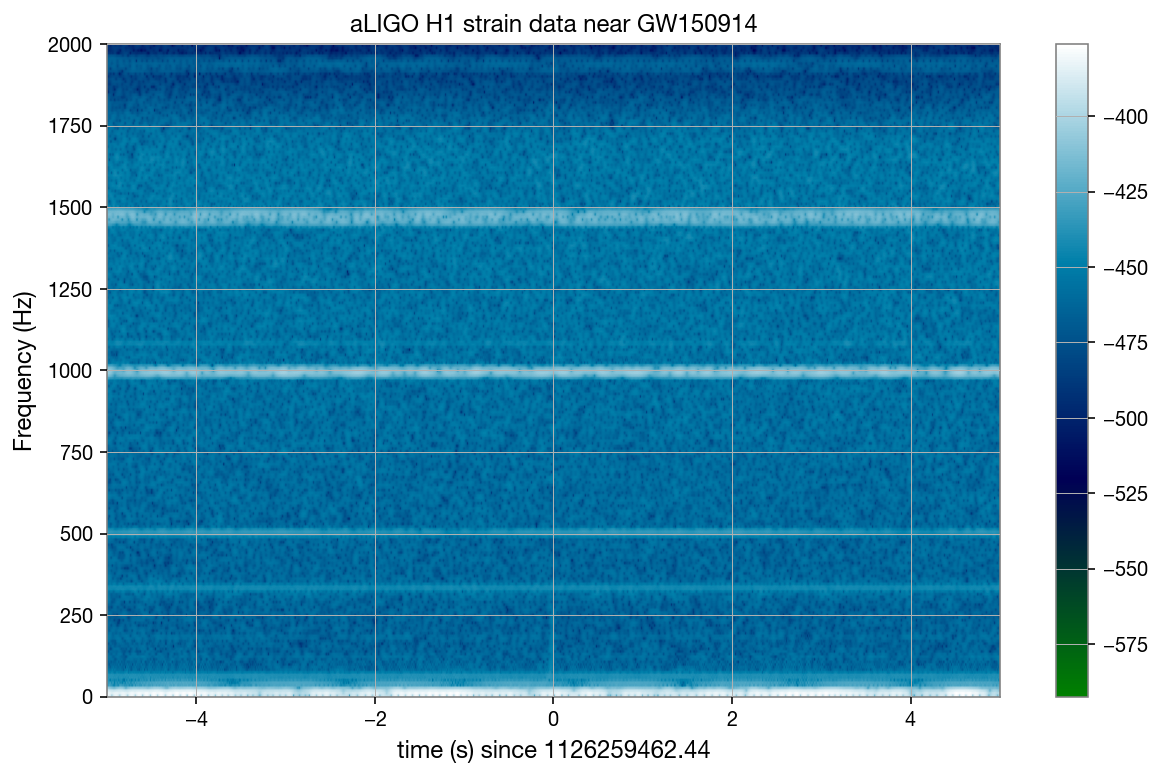

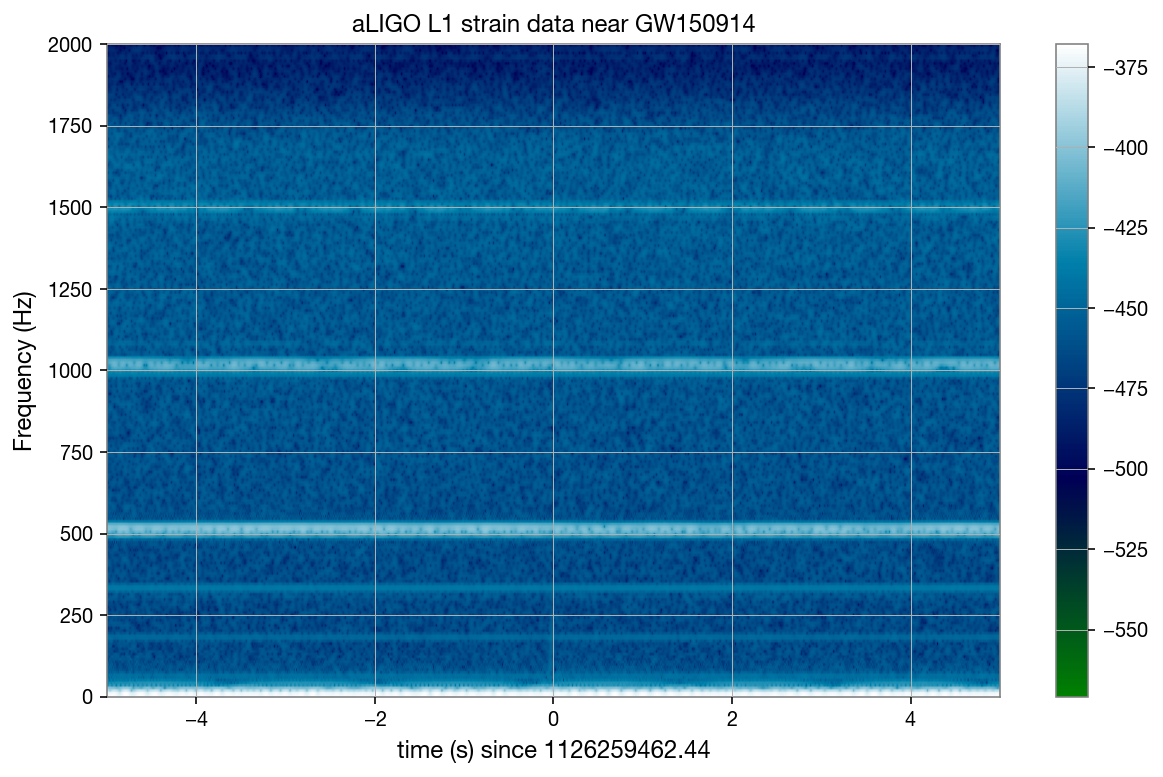

In [20]:
if make_plots:
    # index into the strain time series for this time interval:
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

    # pick a shorter FTT time interval, like 1/8 of a second:
    NFFT = int(fs/8)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15./16)
    # and choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    # the right colormap is all-important! See:
    # http://matplotlib.org/examples/color/colormaps_reference.html
    # viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
    #spec_cmap='viridis'
    spec_cmap='ocean'

    # Plot the H1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram.'+plottype)

    # Plot the L1 spectrogram:
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-deltat, deltat, 0, 2000])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig(eventname+'_L1_spectrogram.'+plottype)

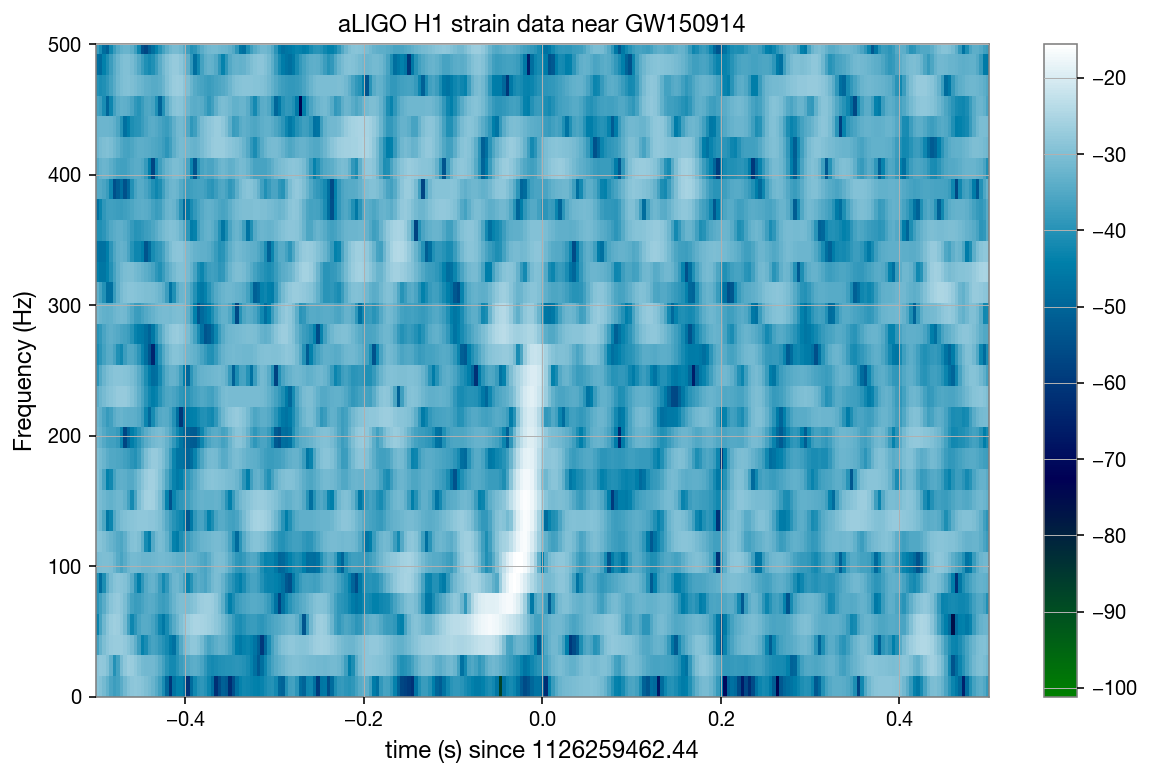

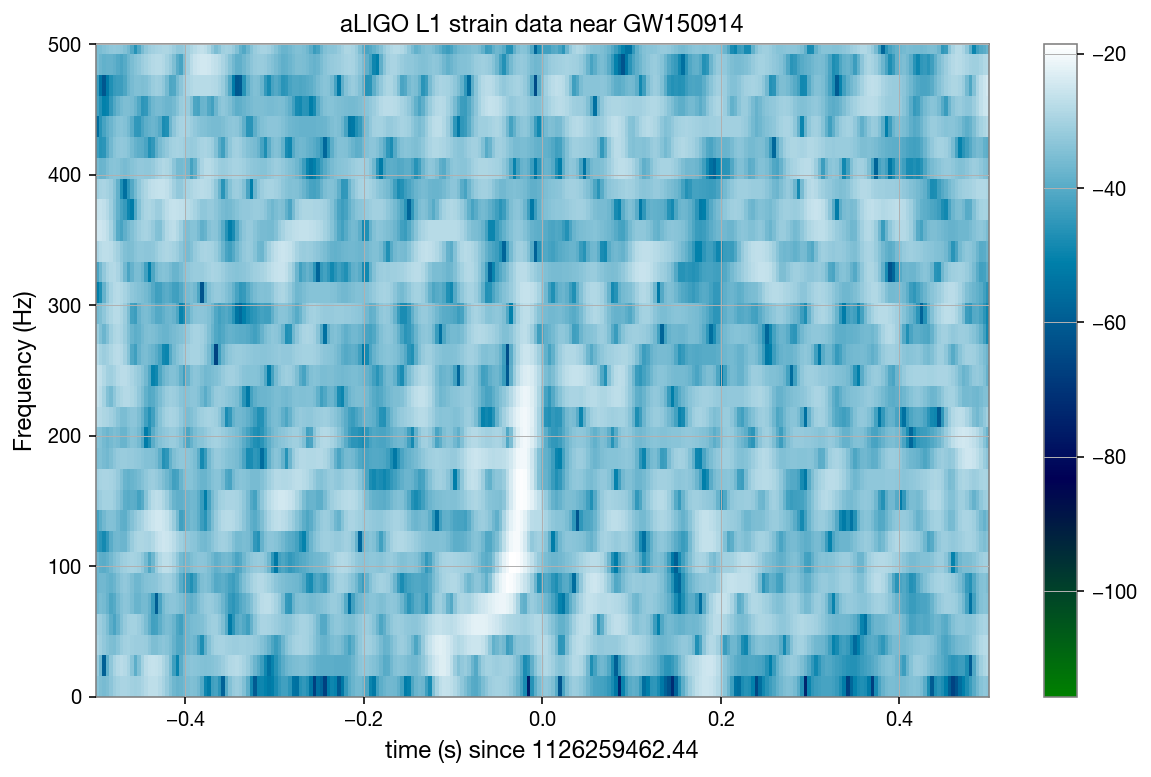

In [21]:
if make_plots:
    #  plot the whitened data, zooming in on the signal region:

    # pick a shorter FTT time interval, like 1/16 of a second:
    NFFT = int(fs/16.0)
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15/16.0)
    # choose a window that minimizes "spectral leakage" 
    # (https://en.wikipedia.org/wiki/Spectral_leakage)
    window = np.blackman(NFFT)

    # Plot the H1 whitened spectrogram around the signal
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-0.5, 0.5, 0, 500])
    plt.title('aLIGO H1 strain data near '+eventname)
    plt.savefig(eventname+'_H1_spectrogram_whitened.'+plottype)

    # Plot the L1 whitened spectrogram around the signal
    plt.figure(figsize=(10,6))
    spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                            noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
    plt.xlabel('time (s) since '+str(tevent))
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([-0.5, 0.5, 0, 500])
    plt.title('aLIGO L1 strain data near '+eventname)
    plt.savefig(eventname+'_L1_spectrogram_whitened.'+plottype)

In [22]:
# read in the template (plus and cross) and parameters for the theoretical waveform
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    print("You can download it from https://losc.ligo.org/s/events/"+eventname+'/'+fn_template)
    print("Quitting.")
    quit()

Properties of waveform template in GW150914_4_template.hdf5
Waveform family = b'lalsim.SEOBNRv2'
Masses = 41.74, 29.24 Msun
Mtot = 70.98 Msun, mfinal = 67.43 Msun 
Spins = 0.35, -0.77
Freq at inband, peak = 43.05, 169.84 Hz
Time at inband, peak = -0.08, -0.02 s
Duration (s) inband-peak = 0.06 s
N_cycles inband-peak = 4
v/c at peak = 0.57
Radius of final BH = 199 km


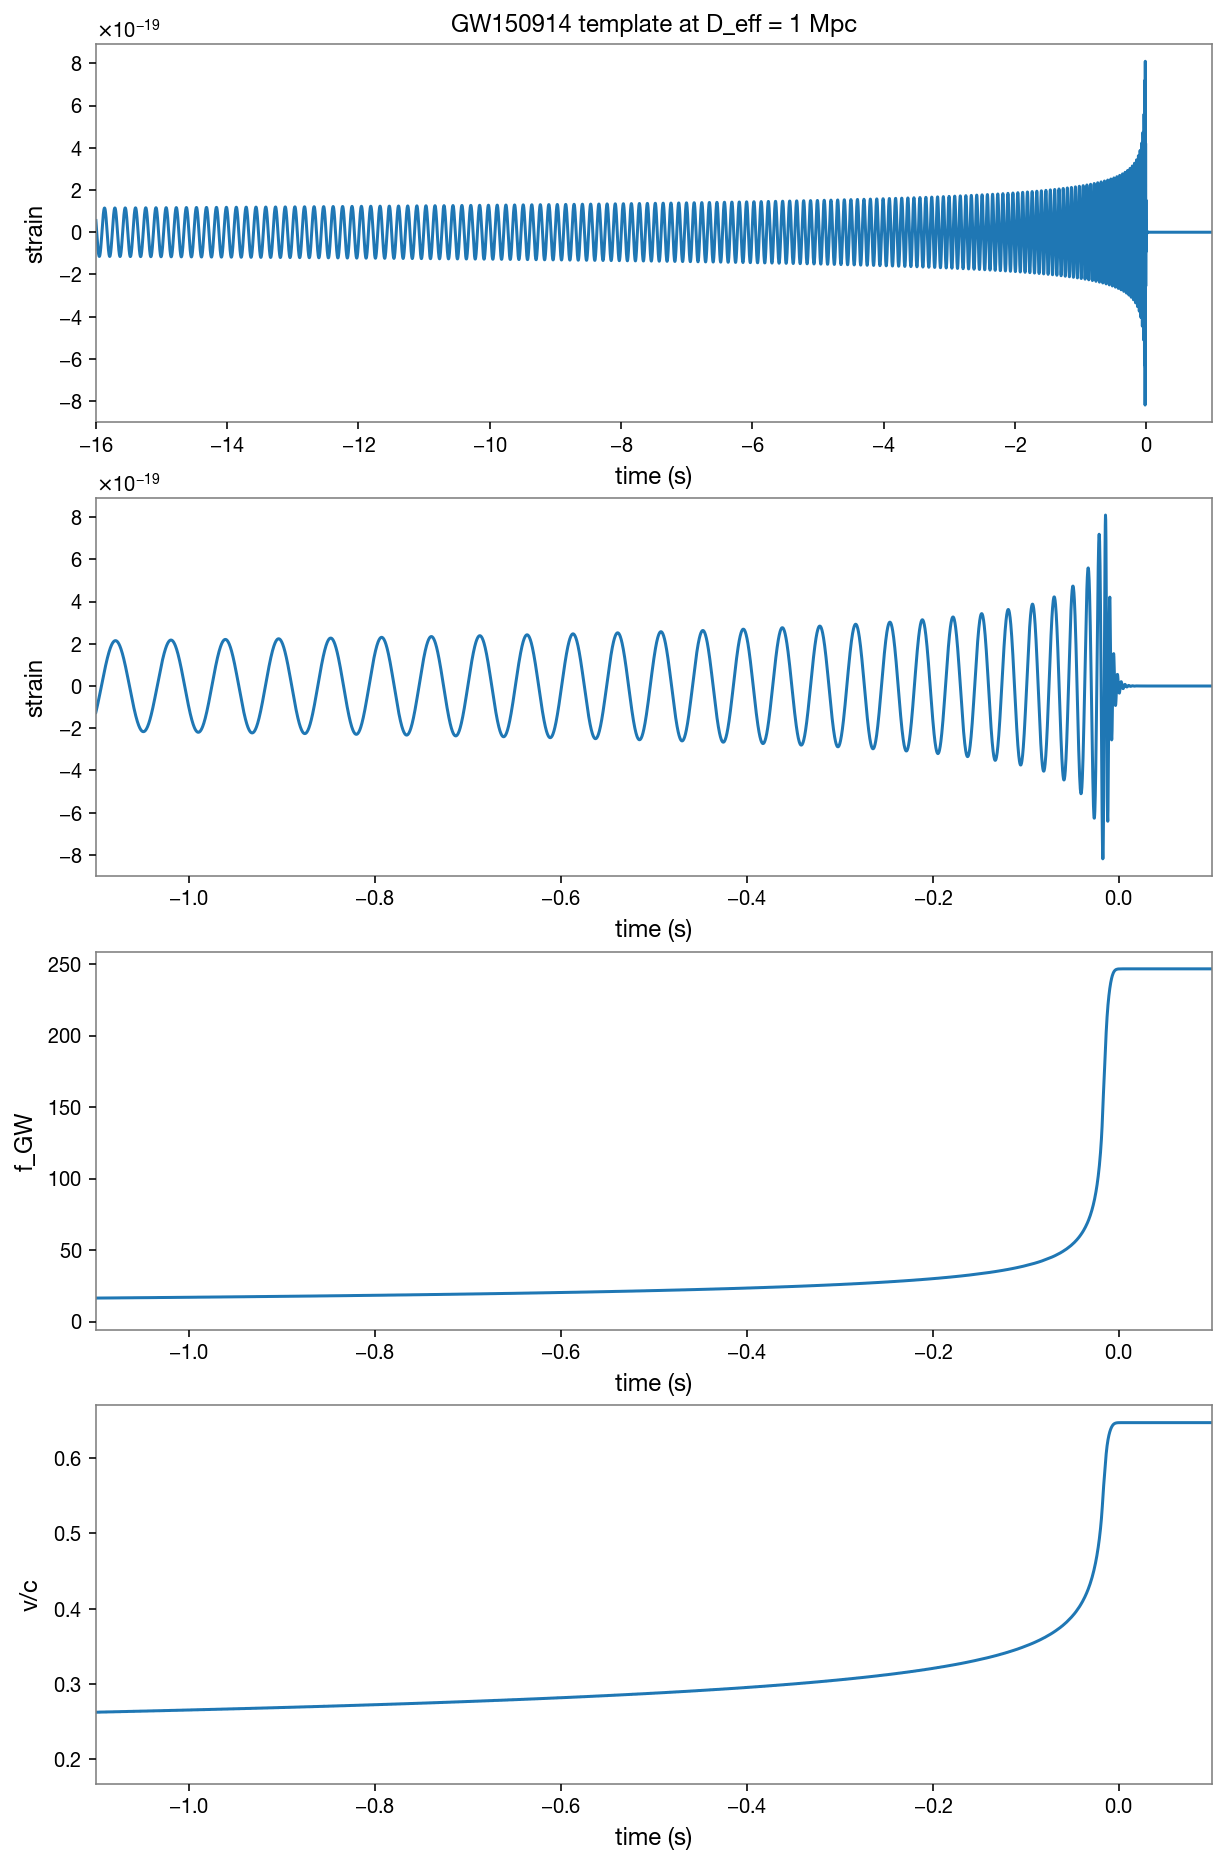

In [23]:
# extract metadata from the template file:
template_p, template_c = f_template["template"][...]
t_m1 = f_template["/meta"].attrs['m1']
t_m2 = f_template["/meta"].attrs['m2']
t_a1 = f_template["/meta"].attrs['a1']
t_a2 = f_template["/meta"].attrs['a2']
t_approx = f_template["/meta"].attrs['approx']
f_template.close()
# the template extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
template_offset = 16.

# whiten the templates:
template_p_whiten = whiten(template_p,psd_H1,dt)
template_c_whiten = whiten(template_c,psd_H1,dt)
template_p_whitenbp = filtfilt(bb, ab, template_p_whiten) / normalization
template_c_whitenbp = filtfilt(bb, ab, template_c_whiten) / normalization

# Compute, print and plot some properties of the template:

# constants:
clight = 2.99792458e8                # m/s
G = 6.67259e-11                      # m^3/kg/s^2 
MSol = 1.989e30                      # kg

# template parameters: masses in units of MSol:
t_mtot = t_m1+t_m2
# final BH mass is typically 95% of the total initial mass:
t_mfin = t_mtot*0.95
# Final BH radius, in km:
R_fin = 2*G*t_mfin*MSol/clight**2/1000.

# complex template:
template = (template_p + template_c*1.j) 
ttime = time-time[0]-template_offset

# compute the instantaneous frequency of this chirp-like signal:
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
# iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

# compute v/c:
voverc = (G*t_mtot*MSol*np.pi*fGW/clight**3)**(1./3.)

# index where f_GW is in-band:
f_inband = fband[0]
iband = np.where(fGW > f_inband)[0][0]
# index at the peak of the waveform:
ipeak = np.argmax(np.abs(template))

# number of cycles between inband and peak:
Ncycles = (tphase[ipeak]-tphase[iband])/(2.*np.pi)

print('Properties of waveform template in {0}'.format(fn_template))
print("Waveform family = {0}".format(t_approx))
print("Masses = {0:.2f}, {1:.2f} Msun".format(t_m1,t_m2))
print('Mtot = {0:.2f} Msun, mfinal = {1:.2f} Msun '.format(t_mtot,t_mfin))
print("Spins = {0:.2f}, {1:.2f}".format(t_a1,t_a2))
print('Freq at inband, peak = {0:.2f}, {1:.2f} Hz'.format(fGW[iband],fGW[ipeak]))
print('Time at inband, peak = {0:.2f}, {1:.2f} s'.format(ttime[iband],ttime[ipeak]))
print('Duration (s) inband-peak = {0:.2f} s'.format(ttime[ipeak]-ttime[iband]))
print('N_cycles inband-peak = {0:.0f}'.format(Ncycles))
print('v/c at peak = {0:.2f}'.format(voverc[ipeak]))
print('Radius of final BH = {0:.0f} km'.format(R_fin))

if make_plots:
    plt.figure(figsize=(10,16))
    plt.subplot(4,1,1)
    plt.plot(ttime,template_p)
    plt.xlim([-template_offset,1.])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,2)
    plt.plot(ttime,template_p)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
    #plt.title(eventname+' template at D_eff = 1 Mpc')
    
    plt.subplot(4,1,3)
    plt.plot(ttime,fGW)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('f_GW')
    #plt.title(eventname+' template f_GW')
    
    plt.subplot(4,1,4)
    plt.plot(ttime,voverc)
    plt.xlim([-1.1,0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('v/c')
    #plt.title(eventname+' template v/c')
    plt.savefig(eventname+'_template.'+plottype)


For detector H1, maximum at 1126259462.4395 with SNR = 18.6, D_eff = 814.44, horizon = 1889.6 Mpc
For detector L1, maximum at 1126259462.4324 with SNR = 13.2, D_eff = 999.74, horizon = 1650.6 Mpc


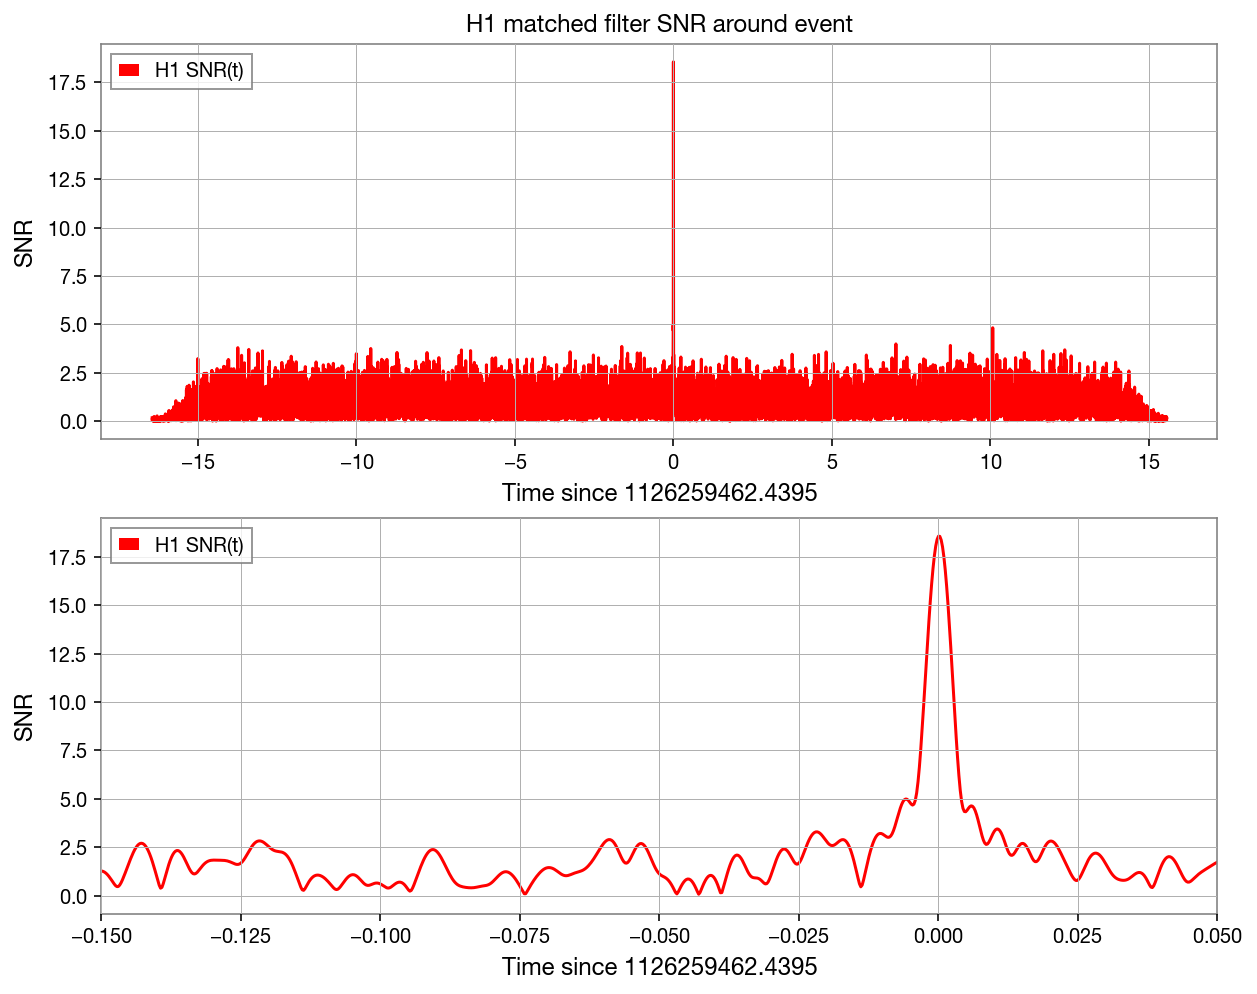

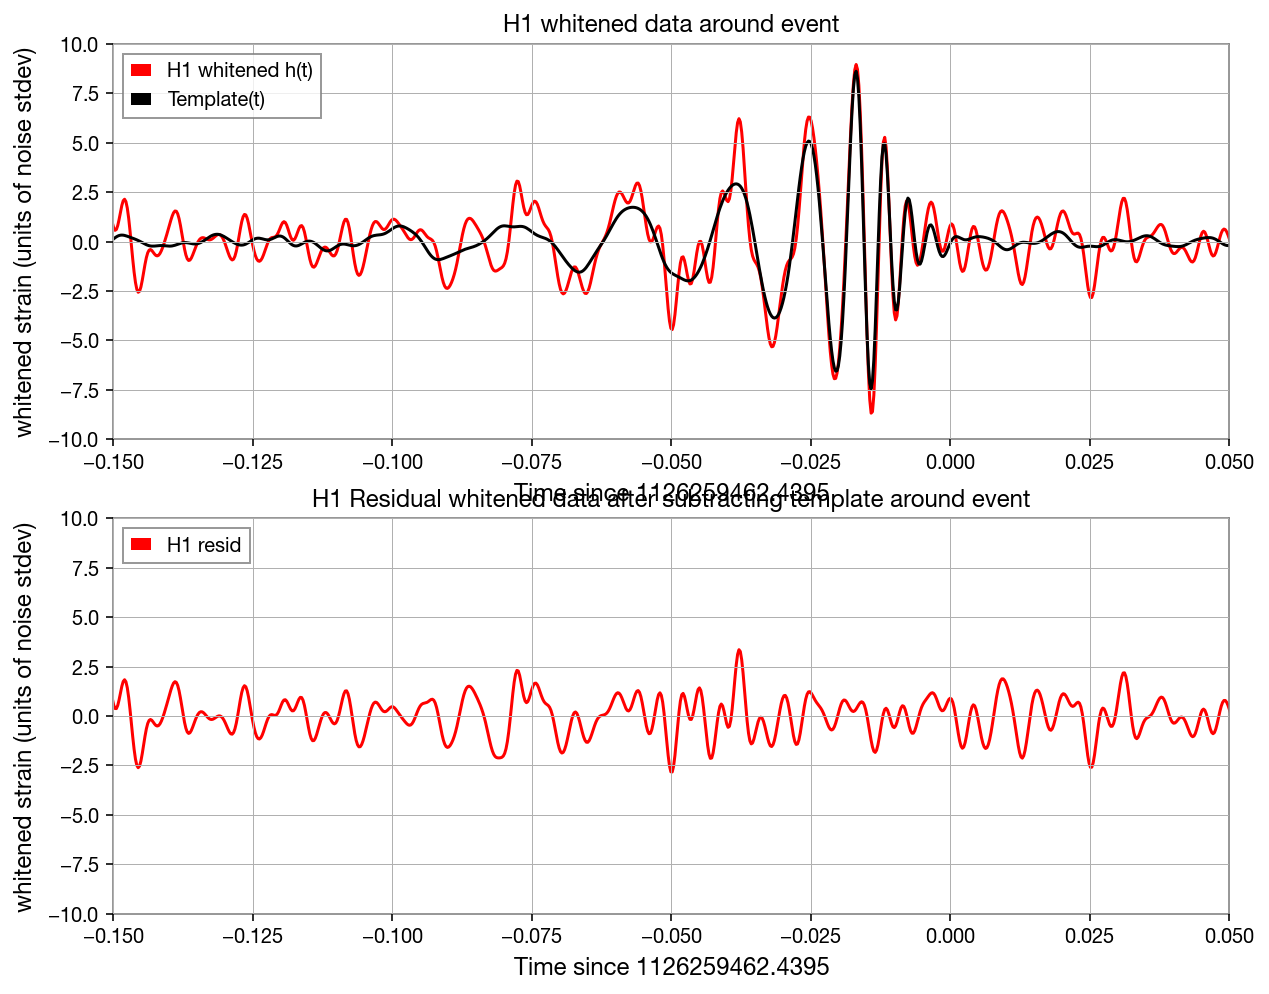

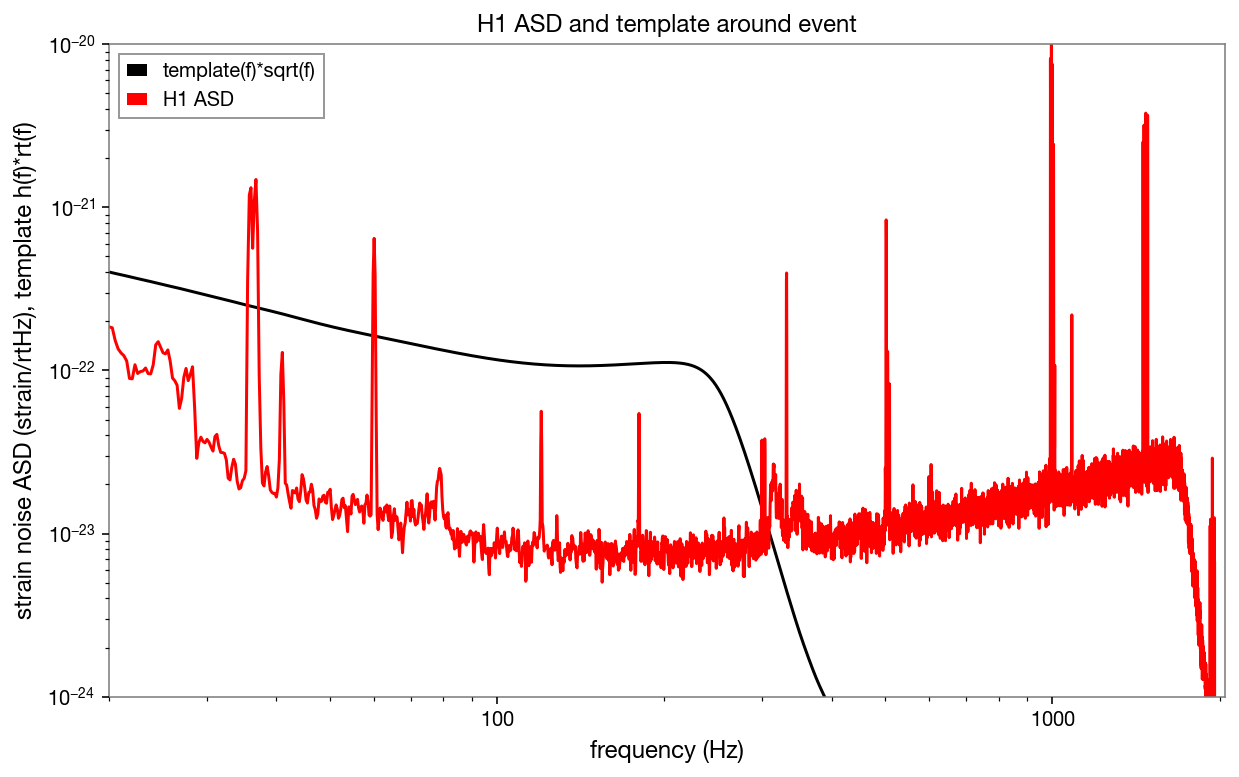

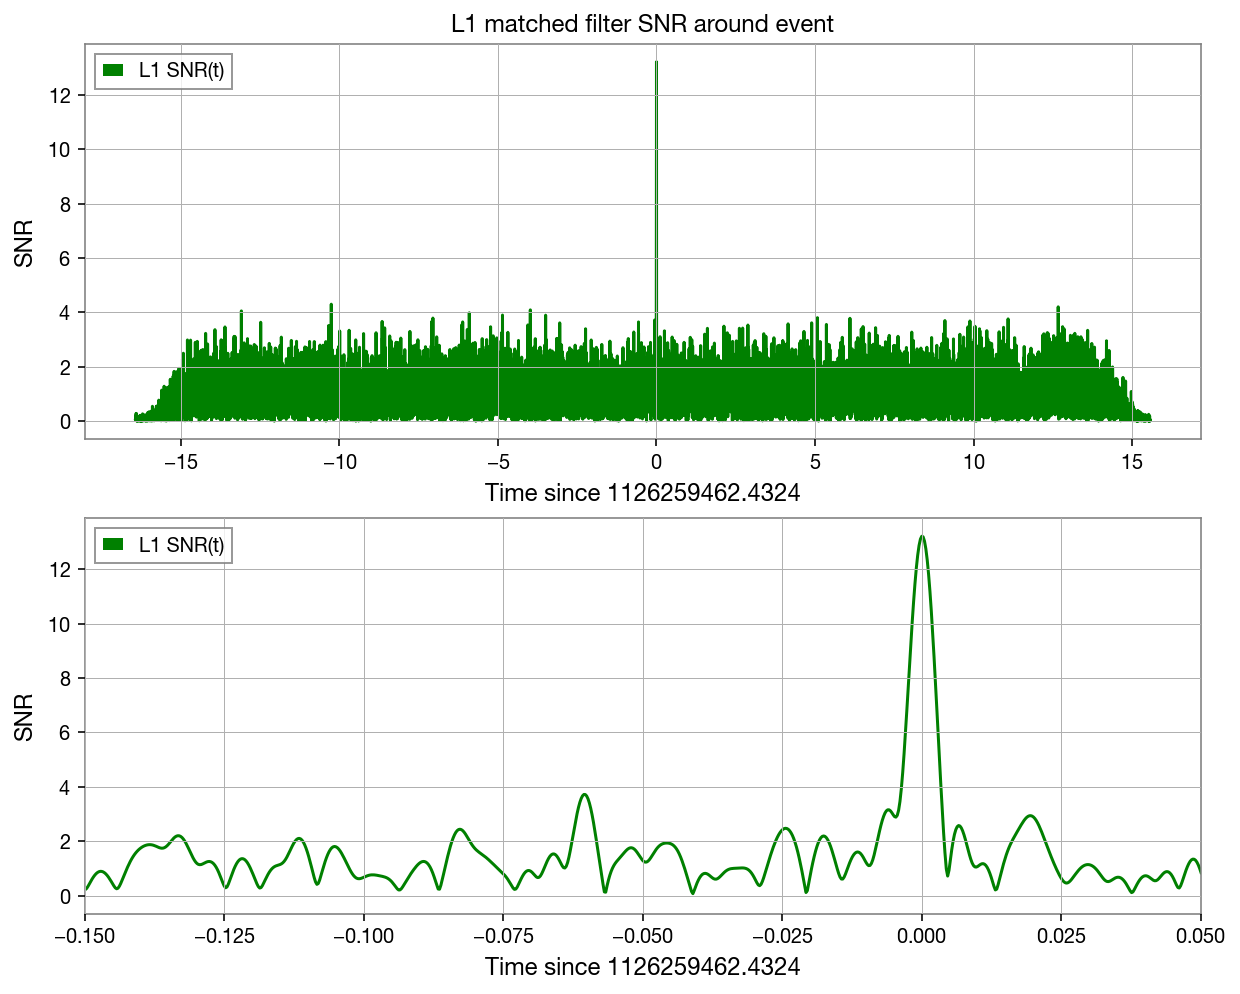

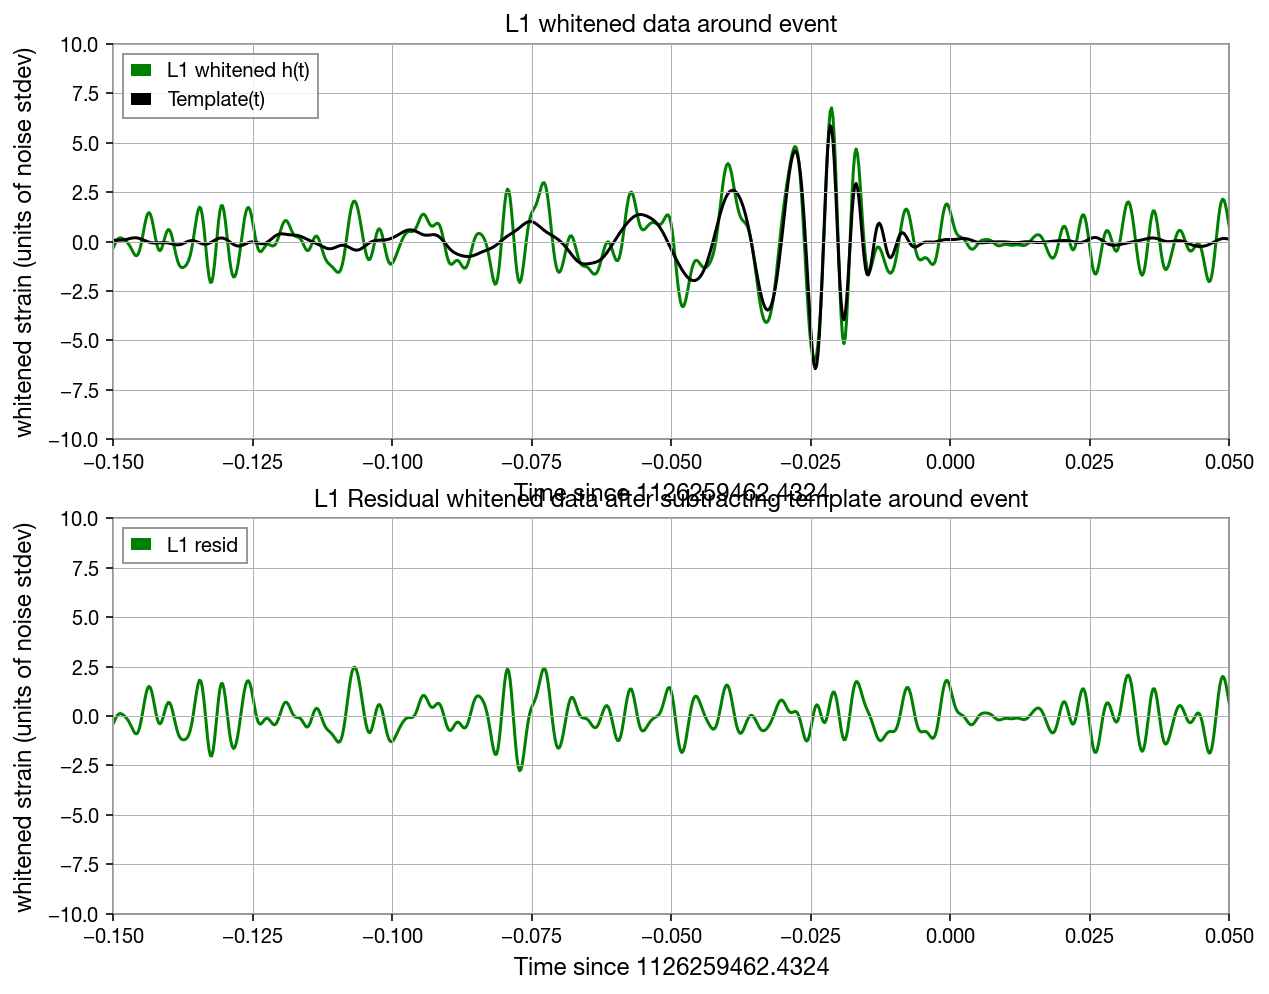

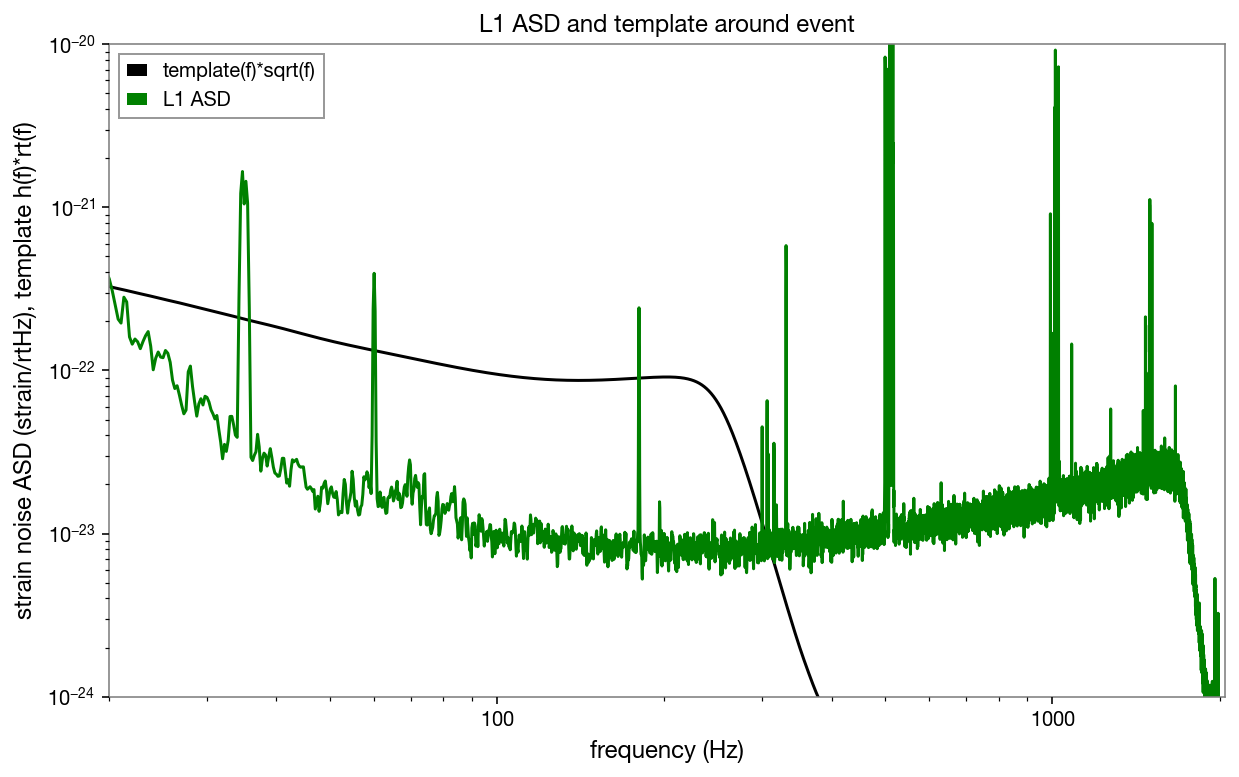

In [25]:
# -- To calculate the PSD of the data, choose an overlap and a window (common to all detectors)
#   that minimizes "spectral leakage" https://en.wikipedia.org/wiki/Spectral_leakage
NFFT = 4*fs
psd_window = np.blackman(NFFT)
# and a 50% overlap:
NOVL = NFFT/2

# define the complex template, common to both detectors:
template = (template_p + template_c*1.j) 
# We will record the time where the data match the END of the template.
etime = time+template_offset
# the length and sampling rate of the template MUST match that of the data.
datafreq = np.fft.fftfreq(template.size)*fs
df = np.abs(datafreq[1] - datafreq[0])

# to remove effects at the beginning and end of the data stretch, window the data
# https://en.wikipedia.org/wiki/Window_function#Tukey_window
try:   dwindow = signal.tukey(template.size, alpha=1./8)  # Tukey window preferred, but requires recent scipy version 
except: dwindow = signal.blackman(template.size)          # Blackman window OK if Tukey is not available

# prepare the template fft.
template_fft = np.fft.fft(template*dwindow) / fs

# loop over the detectors
dets = ['H1', 'L1']
for det in dets:

    if det == 'L1': data = strain_L1.copy()
    else:           data = strain_H1.copy()

    # -- Calculate the PSD of the data.  Also use an overlap, and window:
    data_psd, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)

    # Take the Fourier Transform (FFT) of the data and the template (with dwindow)
    data_fft = np.fft.fft(data*dwindow) / fs

    # -- Interpolate to get the PSD values at the needed frequencies
    power_vec = np.interp(np.abs(datafreq), freqs, data_psd)

    # -- Calculate the matched filter output in the time domain:
    # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
    # Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
    # so the result will be plotted as a function of time off-set between the template and the data:
    optimal = data_fft * template_fft.conjugate() / power_vec
    optimal_time = 2*np.fft.ifft(optimal)*fs

    # -- Normalize the matched filter output:
    # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
    # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
    sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at the END of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the "effective distance" (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    # apply time offset, phase, and d_eff to template 
    template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
    template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude
    
    # Whiten and band-pass the template for plotting
    template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
    template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template
    
    print('For detector {0}, maximum at {1:.4f} with SNR = {2:.1f}, D_eff = {3:.2f}, horizon = {4:0.1f} Mpc' 
          .format(det,timemax,SNRmax,d_eff,horizon))

    if make_plots:

        # plotting changes for the detectors:
        if det == 'L1': 
            pcolor='g'
            strain_whitenbp = strain_L1_whitenbp
            template_L1 = template_match.copy()
        else:
            pcolor='r'
            strain_whitenbp = strain_H1_whitenbp
            template_H1 = template_match.copy()

        # -- Plot the result
        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        #plt.ylim([0,25.])
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.title(det+' matched filter SNR around event')

        # zoom in
        plt.subplot(2,1,2)
        plt.plot(time-timemax, SNR, pcolor,label=det+' SNR(t)')
        plt.grid('on')
        plt.ylabel('SNR')
        plt.xlim([-0.15,0.05])
        #plt.xlim([-0.3,+0.3])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.legend(loc='upper left')
        plt.savefig(eventname+"_"+det+"_SNR."+plottype)

        plt.figure(figsize=(10,8))
        plt.subplot(2,1,1)
        plt.plot(time-tevent,strain_whitenbp,pcolor,label=det+' whitened h(t)')
        plt.plot(time-tevent,template_match,'k',label='Template(t)')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' whitened data around event')

        plt.subplot(2,1,2)
        plt.plot(time-tevent,strain_whitenbp-template_match,pcolor,label=det+' resid')
        plt.ylim([-10,10])
        plt.xlim([-0.15,0.05])
        plt.grid('on')
        plt.xlabel('Time since {0:.4f}'.format(timemax))
        plt.ylabel('whitened strain (units of noise stdev)')
        plt.legend(loc='upper left')
        plt.title(det+' Residual whitened data after subtracting template around event')
        plt.savefig(eventname+"_"+det+"_matchtime."+plottype)
                 
        # -- Display PSD and template
        # must multiply by sqrt(f) to plot template fft on top of ASD:
        plt.figure(figsize=(10,6))
        template_f = np.absolute(template_fft)*np.sqrt(np.abs(datafreq)) / d_eff
        plt.loglog(datafreq, template_f, 'k', label='template(f)*sqrt(f)')
        plt.loglog(freqs, np.sqrt(data_psd),pcolor, label=det+' ASD')
        plt.xlim(20, fs/2)
        plt.ylim(1e-24, 1e-20)
        plt.grid()
        plt.xlabel('frequency (Hz)')
        plt.ylabel('strain noise ASD (strain/rtHz), template h(f)*rt(f)')
        plt.legend(loc='upper left')
        plt.title(det+' ASD and template around event')
        plt.savefig(eventname+"_"+det+"_matchfreq."+plottype)

In [26]:
# make wav (sound) files from the whitened data, +-2s around the event.

from scipy.io import wavfile

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)

deltat_sound = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxd = np.where((time >= tevent-deltat_sound) & (time < tevent+deltat_sound))

# write the files:
write_wavfile(eventname+"_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxd])
write_wavfile(eventname+"_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxd])

# re-whiten the template using the smoothed PSD; it sounds better!
template_p_smooth = whiten(template_p,psd_smooth,dt)

# and the template, sooming in on [-3,+1] seconds around the merger:
indxt = np.where((time >= (time[0]+template_offset-deltat_sound)) & (time < (time[0]+template_offset+deltat_sound)))
write_wavfile(eventname+"_template_whiten.wav",int(fs), template_p_smooth[indxt])

In [27]:
from IPython.display import Audio

fna = eventname+"_template_whiten.wav"
print(fna)
Audio(fna)

GW150914_template_whiten.wav


In [28]:

fna = eventname+"_H1_whitenbp.wav"
print(fna)
Audio(fna)

GW150914_H1_whitenbp.wav


In [29]:
# function that shifts frequency of a band-passed signal
def reqshift(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    # print T,df,nbins,x.real.shape
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    y[0:nbins]=0.
    z = np.fft.irfft(y)
    return z

# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile(eventname+"_H1_shifted.wav",int(fs), strain_H1_shifted[indxd])
write_wavfile(eventname+"_L1_shifted.wav",int(fs), strain_L1_shifted[indxd])

# and the template:
template_p_shifted = reqshift(template_p_smooth,fshift=fshift,sample_rate=fs)
write_wavfile(eventname+"_template_shifted.wav",int(fs), template_p_shifted[indxt])

In [30]:
fna = eventname+"_template_shifted.wav"
print(fna)
Audio(fna)

GW150914_template_shifted.wav


In [31]:
fna = eventname+"_H1_shifted.wav"
print(fna)
Audio(fna)


GW150914_H1_shifted.wav


In [32]:
data_segments = 1
if data_segments:
    # read in the data at 4096 Hz:
    # fn = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
    strain, time, chan_dict = rl.loaddata(fn_L1, 'H1')

    print("Contents of all the key, value pairs in chan_dict")
    for keys,values in chan_dict.items():
        print(keys)
        print(values)

    print('Total number of non-NaNs in these data = ',np.sum(~np.isnan(strain)))
    print('GPS start, GPS stop and length of  all data in this file = ',time[0], time[-1],len(strain))

    # select the level of data quality; default is "DATA" but "CBC_CAT3" is a conservative choice:
    DQflag = 'CBC_CAT3'
    # readligo.py method for computing segments (start and stop times with continuous valid data):
    segment_list = rl.dq_channel_to_seglist(chan_dict[DQflag])
    print('Number of segments with DQflag',DQflag,' = ',len(segment_list))

    # loop over seconds and print out start, stop and length:
    iseg = 0
    for segment in segment_list:
        time_seg = time[segment]
        seg_strain = strain[segment]
        print('GPS start, GPS stop and length of segment',iseg, \
            'in this file = ',time_seg[0], time_seg[-1], len(seg_strain))
        iseg = iseg+1
        # here is where you would insert code to analyze the data in this segment.

    # now look at segments with no CBC hardware injections:
    DQflag = 'NO_CBC_HW_INJ'
    segment_list = rl.dq_channel_to_seglist(chan_dict['NO_CBC_HW_INJ'])
    print('Number of segments with DQflag',DQflag,' = ',len(segment_list))
    iseg = 0
    for segment in segment_list:
        time_seg = time[segment]
        seg_strain = strain[segment]
        print('GPS start, GPS stop and length of segment',iseg, \
            'in this file = ',time_seg[0], time_seg[-1], len(seg_strain))
        iseg = iseg+1

Contents of all the key, value pairs in chan_dict
DATA
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CBC_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT2
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
BURST_CAT3
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CBC_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_BURST_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_DETCHAR_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NO_CW_HW_INJ
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NO_STOCH_HW_INJ
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DEFAULT
[1 1 1 1

/Users/sophiewillis/opt/anaconda3/lib/python3.9/site-packages/h5py/_hl/dataset.py:312: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  warn("dataset.value has been deprecated. "


In [33]:
# time vector around event
times = time-tevent
# zoom in on [-0.2,0.05] seconds around event
irange = np.nonzero((times >= -0.2) & (times < 0.05))
# construct a data structure for a csv file:
dat = [times[irange], strain_H1_whitenbp[irange],strain_L1_whitenbp[irange],
      template_H1[irange],template_L1[irange] ]
datcsv = np.array(dat).transpose()
# make a csv filename, header, and format
fncsv = eventname+'_data.csv'
headcsv = eventname+' time-'+str(tevent)+ \
    ' (s),H1_data_whitened,L1_data_whitened,H1_template_whitened,L1_template_whitened'
fmtcsv = ",".join(["%10.6f"] * 5)
np.savetxt(fncsv, datcsv, fmt=fmtcsv, header=headcsv)

print("Wrote whitened data to file {0}".format(fncsv))
print("You can download this file by clicking 'jupyter' in the top left corner, or using the 'data' menu in Azure.")

Wrote whitened data to file GW150914_data.csv
You can download this file by clicking 'jupyter' in the top left corner, or using the 'data' menu in Azure.
